In [23]:
# https://zzsza.github.io/data/2019/09/02/simpy-intro/

import simpy
    
def clock(env, name, tick):
    while True:
        print(name, env.now)
        yield env.timeout(tick)

env = simpy.Environment()
env.process(clock(env, 'fast', 0.5))
env.process(clock(env, 'slow', 1))
    
env.run(until=2)

fast 0
slow 0
fast 0.5
slow 1
fast 1.0
fast 1.5


customer comes I sold 2 at time 0.16
customer comes I sold 4 at time 0.53
customer comes I sold 2 at time 0.69
customer comes I sold 3 at time 0.88
customer comes I sold 3 at time 1.0
customer comes I sold 1 at time 1.01
customer comes I sold 3 at time 1.11
customer comes I sold 3 at time 1.44
at 1 placed order for 0
customer comes I sold 2 at time 1.61
customer comes I sold 1 at time 1.97
customer comes I sold 4 at time 1.99
0 is out of stock at 2.08
0 is out of stock at 2.38
0 is out of stock at 2.79
0 is out of stock at 3.11
0 is out of stock at 3.26
0 is out of stock at 3.28
at 3 recieved order for 0
customer comes I sold 2 at time 3.46
customer comes I sold 4 at time 4.04
customer comes I sold 4 at time 4.06
customer comes I sold 4 at time 4.12
customer comes I sold 1 at time 4.39
customer comes I sold 1 at time 4.56
customer comes I sold 2 at time 4.63
customer comes I sold 1 at time 4.82
customer comes I sold 1 at time 4.92
customer comes I sold 3 at time 5.15
at 5 placed order 

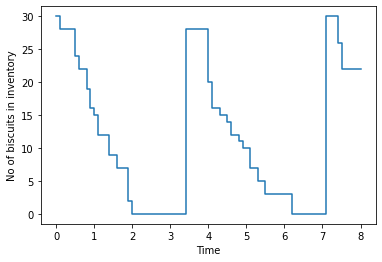

In [ ]:
# https://asadali047.medium.com/inventory-simulation-for-beginners-7ea55eb6c4f8

import numpy as np
import simpy
import matplotlib.pyplot as plt
np.random.seed(0)
from math import ceil

class inventory_simulation:
    def __init__(self, env:simpy.Environment, reorder_level:int, reorder_qty:int) -> None:
        self.reorder_level = reorder_level
        self.reorder_qty = reorder_qty
        self.balance = 0
        self.num_ordered = 0
        self.inventory = self.reorder_qty
        self.env = env
        self.obs_time = []
        self.inventory_level = []
        self.demand =0

    def handle_order(self) -> None:
        print(f'at {round(self.env.now)} placed order for {self.num_ordered}')
        self.num_ordered = self.reorder_level + 1 -self.inventory
        self.num_ordered = ceil(self.num_ordered/self.reorder_qty)*self.reorder_qty
        self.balance -= 50*self.num_ordered
        yield self.env.timeout(2.0)
        self.inventory += self.num_ordered
        self.num_ordered = 0
        print(f'at {round(self.env.now)} recieved order for {self.num_ordered}')

    def generate_interarrival(self) -> np.array:
        return np.random.exponential(0.2)

    def generate_demand(self) -> np.array:
        return np.random.randint(1, 5)

    def observe(self):
        while True:
            self.obs_time.append(self.env.now)
            self.inventory_level.append(self.inventory)
            yield self.env.timeout(0.1)

    def runner_setup(self):
        while True:
            interarrival = self.generate_interarrival()
            yield self.env.timeout(interarrival)

            self.balance -= self.inventory*2*interarrival
            self.demand = self.generate_demand()

            if self.demand < self.inventory:
                self.balance += 100*self.demand
                self.inventory -= self.demand
                print(f'customer comes I sold {self.demand} at time {round(self.env.now,2)}')
            else:
                self.balance += 100*self.inventory
                self.inventory = 0
                print(f'{self.inventory} is out of stock at {round(self.env.now,2)}')

            if self.inventory < self.reorder_level and self.num_ordered ==0:
                self.env.process(self.handle_order())

    def plot_inventory(self):
        plt.figure()
        plt.step(self.obs_time, self.inventory_level)
        plt.xlabel('Time')
        plt.ylabel('No of biscuits in inventory')

def run(simulation:inventory_simulation,until:float):
    simulation.env.process(simulation.runner_setup())
    simulation.env.process(simulation.observe())
    simulation.env.run(until=until)

env = simpy.Environment()

s = inventory_simulation(
    env=env,
    reorder_level=10,
    reorder_qty=30
    )

run(s, 8)
print(s.inventory_level)
s.plot_inventory()

In [ ]:
# https://greatjoy.tistory.com/m/74

import simpy

def car(env, name, station, driving_time, charge_duration):
    yield env.timeout(driving_time) # 차가 돌아다니다가 들어올 시간
    print(f'{name} 차가 충전소에 {env.now}에 도착했습니다.')

    with station.request() as req:
        yield req
        print(f'{name} 차가 충전을 시작한 시간 {env.now}')
        yield env.timeout(charge_duration)
        print(f'{name} 차의 충전이 완료된 시간 {env.now}')


env = simpy.Environment()
station = simpy.Resource(env, capacity=2)

for i in range(4):
	env.process(car(env, f'Car {i}', station, i*2, 5))

env.run()

Car 0 차가 충전소에 0에 도착했습니다.
Car 0 차가 충전을 시작한 시간 0
Car 1 차가 충전소에 2에 도착했습니다.
Car 1 차가 충전을 시작한 시간 2
Car 2 차가 충전소에 4에 도착했습니다.
Car 0 차의 충전이 완료된 시간 5
Car 2 차가 충전을 시작한 시간 5
Car 3 차가 충전소에 6에 도착했습니다.
Car 1 차의 충전이 완료된 시간 7
Car 3 차가 충전을 시작한 시간 7
Car 2 차의 충전이 완료된 시간 10
Car 3 차의 충전이 완료된 시간 12


In [ ]:
# https://studying-haeung.tistory.com/m/15

import simpy 

class Customer(object):
    def __init__(self, env, number):
        self.env = env
        self.number = number 
        #분포에 따라 customer 도착
        self.action = env.process(self.customer_generate())

    def customer_generate(self):
        for i in range(self.number):
            name = 'Customer-%s'%i            
            arrive = self.env.now
            print(name, '%8.3f' %arrive,'카페도착')

            #도착한 고객은 주문하러 이동 
            self.env.process(self.order_coffee(name, staff))

            interval_time = 10
            yield self.env.timeout(interval_time)

    def order_coffee(self, name, staff):
        #직원 요청
        with staff.request() as req:
            yield req

            #직원에게 30초동안 주문 
            ordering_duration = 30
            yield self.env.timeout(ordering_duration)
            print(name, '%8.3f'%self.env.now, '주문완료')

        #주문한 고객은 커피 수령을 위해 대기
        self.env.process(self.wait_for_coffee(name))

    def wait_for_coffee(self, name):
        #30초 대기 후 커피 수령 
        waiting_duration = 30
        yield(self.env.timeout(waiting_duration))
        print(name, '%8.3f' %self.env.now,'커피수령')


print('Starbucks_Example-01')

env = simpy.Environment()
staff = simpy.Resource(env, capacity=2)
customer = Customer(env, 10)

env.run()

Starbucks_Example-01
Customer-0    0.000 카페도착
Customer-1   10.000 카페도착
Customer-2   20.000 카페도착
Customer-0   30.000 주문완료
Customer-3   30.000 카페도착
Customer-1   40.000 주문완료
Customer-4   40.000 카페도착
Customer-5   50.000 카페도착
Customer-0   60.000 커피수령
Customer-2   60.000 주문완료
Customer-6   60.000 카페도착
Customer-1   70.000 커피수령
Customer-3   70.000 주문완료
Customer-7   70.000 카페도착
Customer-8   80.000 카페도착
Customer-2   90.000 커피수령
Customer-4   90.000 주문완료
Customer-9   90.000 카페도착
Customer-3  100.000 커피수령
Customer-5  100.000 주문완료
Customer-4  120.000 커피수령
Customer-6  120.000 주문완료
Customer-5  130.000 커피수령
Customer-7  130.000 주문완료
Customer-6  150.000 커피수령
Customer-8  150.000 주문완료
Customer-7  160.000 커피수령
Customer-9  160.000 주문완료
Customer-8  180.000 커피수령
Customer-9  190.000 커피수령


In [ ]:
# 발주량 계산
#    현 재고 취득
#    입하 예정량 취득
#    적정 재고 계산
#        예측 출하량 계산
#        안전재고 계산

# 발주량 수정
#    메

In [ ]:
import simpy

class HatchuSimulation:
    pass